# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

random_state = 2250

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias_data = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias_rows, azdias_columns = azdias_data.shape
feat_info_rows, feat_info_columns = feat_info.shape

print(f'The AZDIAS Dataset includes {azdias_rows} rows and {azdias_columns} columns.')
print(f'The Feature Summary includes {feat_info_rows} rows and {feat_info_columns} columns.')


The AZDIAS Dataset includes 891221 rows and 85 columns.
The Feature Summary includes 85 rows and 4 columns.


In [4]:
azdias_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

**Finding**: <br>
Looking at the data you can see that there are missing values because of the defferences of the Non-Null Counts. The second thing is we have three datatypes within the dataset (float64, int64 and object).

In [5]:
# Getting an overview of the data itself
azdias_data.head(25)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


**Finding**: <br>
We already see NaN values in the data.

In [6]:
# Getting some statistics
azdias_data.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [7]:
# Getting an overview of the features.
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


In [9]:
type(feat_info['missing_or_unknown'][0])

str

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

# Checking the data for missing values:
print(f'There are {azdias_data.isna().sum().sum()} missing values in the dataset before preprocessing.')

There are 4896838 missing values in the dataset before preprocessing.


In [11]:
# Converting feat_info['missing_or_unknown'] in list of values to replace the values with NaN

list_of_missing_values = []

for values in feat_info['missing_or_unknown']:
    list_of_missing_values.append(values[1:-1].split(',')) # eliminating the brackets '[]' and  splitting the data
    
# Going through every feature to get numeric values as integer and replacing them in the azdias_data with NaN
for i in range(len(feat_info)):
    if list_of_missing_values[i] != ['']: #important step, because there are columns without missing values
        
        # Converting the values to integers (with a view of the 'X' and 'XX' values from feat_info)
        list_of_missing_values[i] = [value if (value == 'X' or value == 'XX') else int(value) for value in list_of_missing_values[i]]
        
        # Replacing the attributes equal to the list of missing values with NaN
        azdias_data = azdias_data.replace({feat_info.iloc[i]['attribute']: list_of_missing_values[i]}, np.nan)

In [12]:
azdias_data.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [13]:
# Checking the data for missing values after preprocessing:
print(f'There are {azdias_data.isna().sum().sum()} missing values in the dataset after preprocessing.')

There are 8373929 missing values in the dataset after preprocessing.


**Finding**: <br>
There are more missing data after preprocessing, so this should be a clue, that the preprocessing has worked.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_values = azdias_data.isna().sum().sort_values(ascending = False)
missing_values

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
KKK                      158064
REGIOTYP                 158064
W_KEIT_KIND_HH           147988
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_ANTG1               116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
VERS_TYP                 111196
HEALTH_TYP               111196
SHOPPER_TYP              111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DE

In [15]:
# To get a relation to the total amount of values a percentage calculation should be done:
missing_values_rel = missing_values[missing_values > 0] / azdias_data.shape[0] * 100
missing_values_rel

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
KKK                      17.735668
REGIOTYP                 17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_ANTG1               13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
SHOPPER_TYP              12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

**Finding**: <br>
What we can see here is that there are four columns with more than 50% of missing values. Lets take a look with a histogram.

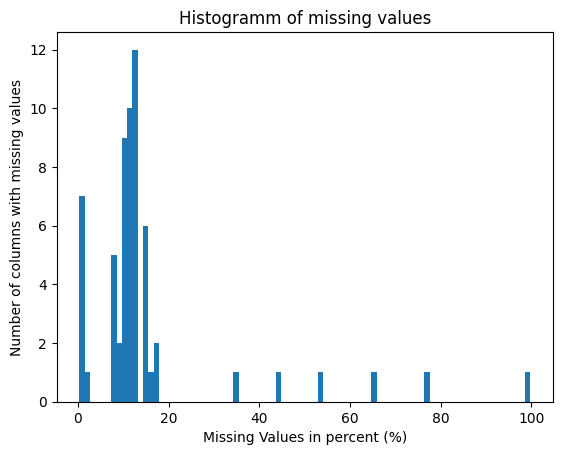

In [16]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_values_rel, bins = 85)

plt.xlabel('Missing Values in percent (%)')
plt.ylabel('Number of columns with missing values')
plt.title('Histogramm of missing values')

plt.show()

**Finding**: <br>
The histogram shows, that there are some columns with more than 20% of missing values (six columns). Regarding the rest of the columns, the missing values are less than 20% of the total amount of values per column. That indicates, that the six columns could be ones to be removed. Lets take a look at the features with more than 20% of missing values with a look to *missing_values_rel*:

In [17]:
# Collecting the names of the columns with outliers
columns = missing_values_rel[missing_values_rel > 20].index
print(columns)

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')


**Finding**: <br>
TITEL_KZ is the academic title someone has. Not everyone has an academic degree, so that is understandable.<br>
AGER_TYP is somewhat charasteristic for older persons.<br>
KK_KUNDENTYP is a consumer pattern - that could be interesting, but with missing values of about 65% encoding would perhaps falsifiy the data.<br>
KBA05_BAUMAX says something about the area this customer is living in.<br>
GEBURTSJAHR is clear the year of birth.<br>
ALTER_HH is the birthdate of the head of household - interesting category. <br>

In a first thought: to fill up or estimate the missing values in these features could lead to some false indications later on. So i would say, we can remove them.

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Dropping the outlier-columns
azdias_data.drop(columns = columns, axis = 1, inplace = True)

# Calculating the new missingvalues and relative part
missing_values_new = azdias_data.isna().sum().sort_values(ascending = False)
missing_values_rel_new = missing_values_new[missing_values_new > 0] / azdias_data.shape[0] * 100
missing_values_rel_new

KKK                      17.735668
REGIOTYP                 17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_ANTG1              14.959701
MOBI_REGIO               14.959701
KBA05_GBZ                14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
PLZ8_ANTG1               13.073637
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
SHOPPER_TYP              12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV      11.176913
CAMEO_INTL_2015          11.147852
CAMEO_DEUG_2015          11.147852
CAMEO_DEU_2015           11.147852
LP_LEBENSPHASE_FEIN      10.954859
RELAT_AB                 10.926022
ARBEIT              

#### Discussion 1.1.2: Assess Missing Data in Each Column

As reported most of the data had less than 20% of missing values. There were only six features with more than 20% of missing values - from 34% up to 99%. So with a look at these six features one can say, that these are less relevant to find customer segments or hard to fill up with realistic data. 
The only thing could be the year of birth (with some statsitical hacks or so), but with "1.2. ALTERSKATEGORIE_GROB" there is a category connected to the age of the persons, which helps better if age is a thing.
So at the end these 6 features were dropped from the data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [19]:
# How much data is missing in each row of the dataset?
missing_values_row = azdias_data.isna().sum(axis = 1)
missing_values_row_sort = missing_values_row.sort_values(ascending = False)

# Similar to the columns lets look at the relative part and plot that in a histogram
missing_values_row_rel = missing_values_row[missing_values_row >0] / (len(azdias_data.columns)) * 100

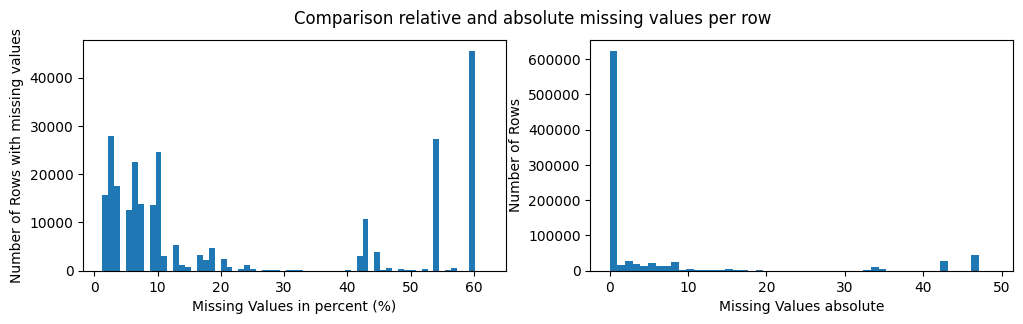

In [20]:
# Countplot didn't work - so i build two histograms

fig, axs = plt.subplots(1,2, figsize = (12,3))
fig.suptitle('Comparison relative and absolute missing values per row')

axs[0].hist(missing_values_row_rel, bins = 65)
axs[0].set_xlabel('Missing Values in percent (%)')
axs[0].set_ylabel('Number of Rows with missing values')

axs[1].hist(missing_values_row, bins = 50)
axs[1].set_xlabel('Missing Values absolute')
axs[1].set_ylabel('Number of Rows')

plt.show()

**Finding**: <br>
Thats interesting - there seem to be a relatively clear possibility to divide the set into two subsets. I would say the first shot could be up to 30% of missing values, the second one could be from 30%.<br>
Be careful reading the data - the absolute values are with all rows, the relative values only with rows containing missing values. And the reading was with default bins. <br>
Regarding that there are 79 columns in the dataset and with a view to the data with more detail - i would suggest to divide the dataset into the following two subsets (regarding the absolute missing values):<br>
One set with up to 10 missing values (looking at absolute missing values), and one with more than 10 missing values - should be around 12.7%. Lets see.

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_row_values_lt10 = azdias_data[missing_values_row < 10]

missing_row_values_gt10 = azdias_data[missing_values_row >= 10]

In [22]:
missing_row_values_gt10.shape

(116478, 79)

In [23]:
missing_row_values_lt10.shape

(774743, 79)

In [24]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Comparison of ten columns
columns = missing_row_values_lt10.columns
comparing_columns = columns[:10]
comparing_columns


Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP'],
      dtype='object')

In [25]:
# Writing a function to plot the comparison of the countplots.

def create_comparison_plot(column):
    """
    This function plots two plots to compare the missing values per column.
    
    INPUT:
    column - the column to compare with
    
    OUTPUT:
    None
    """
    fig, axs = plt.subplots(1,2, figsize = (12,3))
    
    # Countplot didn't work - had trouble with kernel interruption the last two hours...
    axs[0].hist(missing_row_values_lt10[column])
    axs[0].set_title('Missing values < 10')
    axs[0].set_xlabel(column)
    axs[0].set_ylabel('Count')

    axs[1].hist(missing_row_values_gt10[column])
    axs[1].set_title('Missing values >= 10')
    axs[1].set_xlabel(column)
    axs[1].set_ylabel('Count')
    
    plt.show()

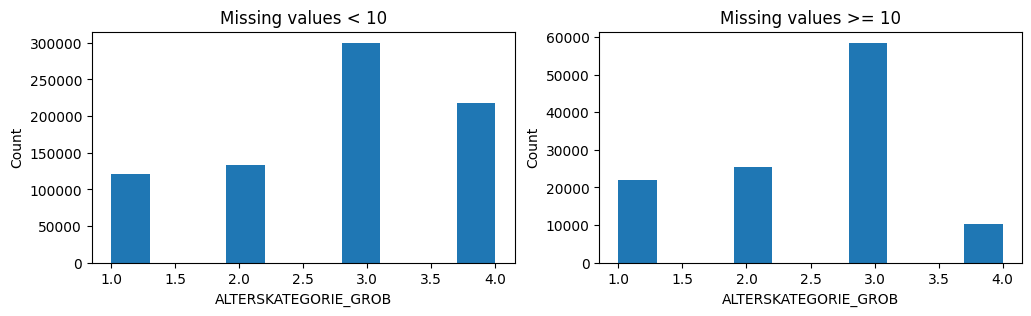

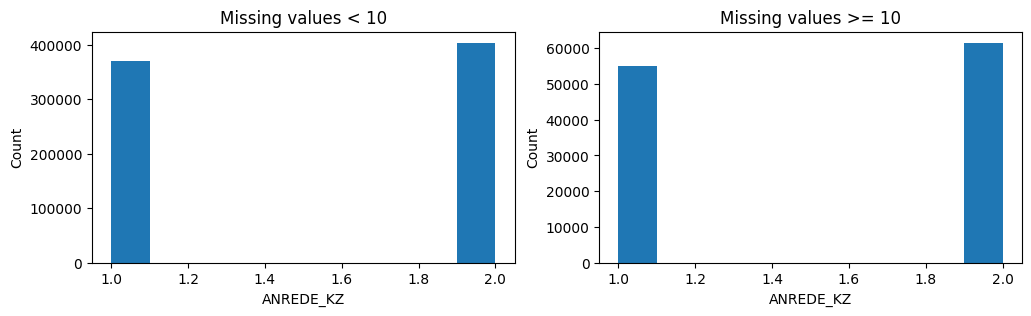

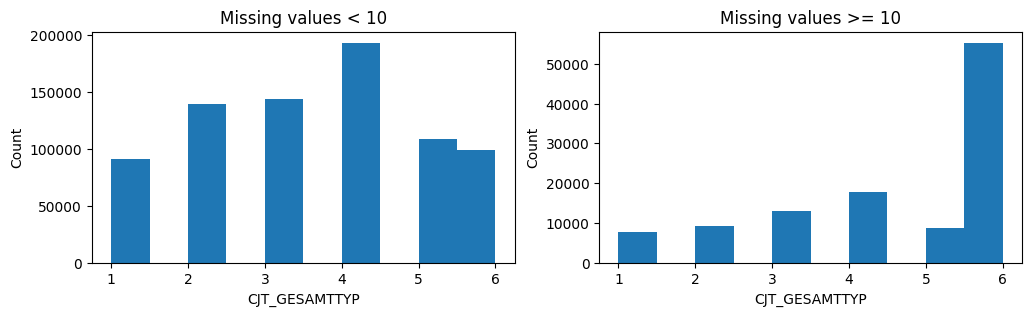

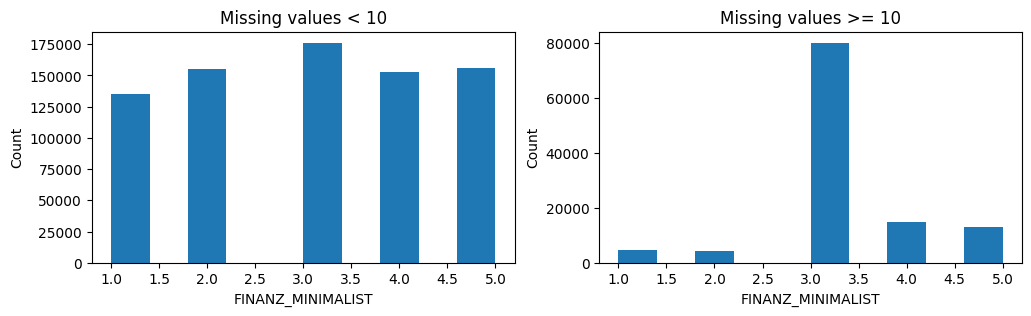

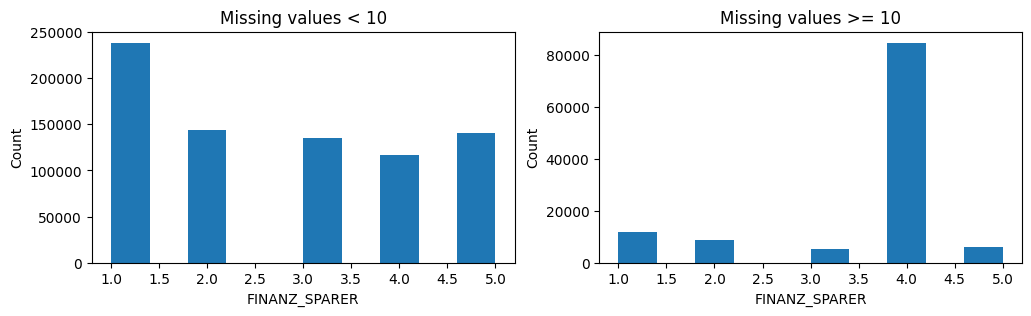

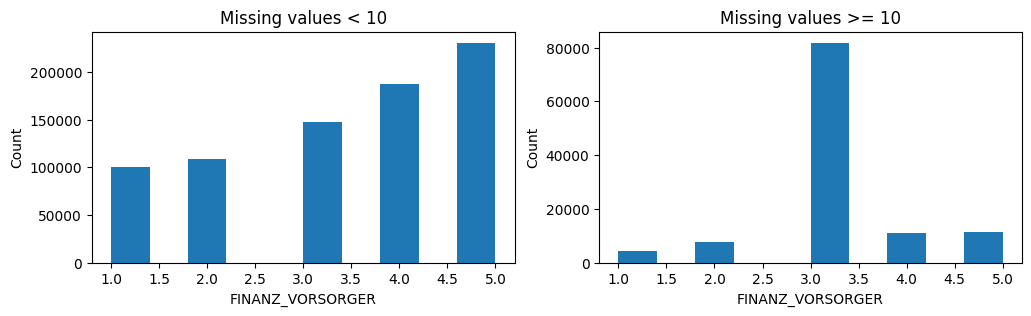

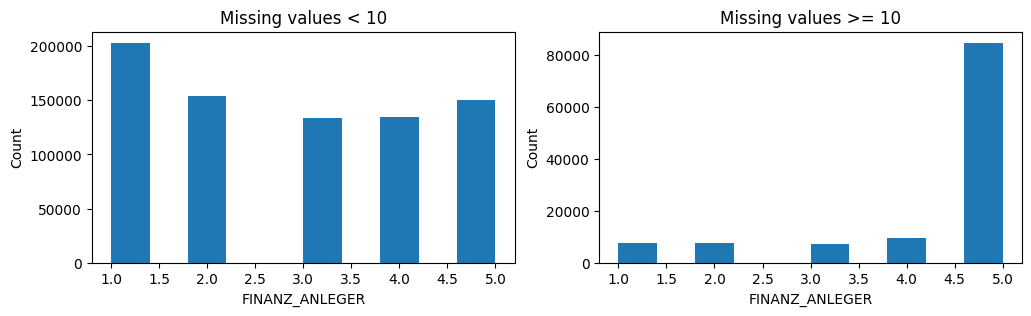

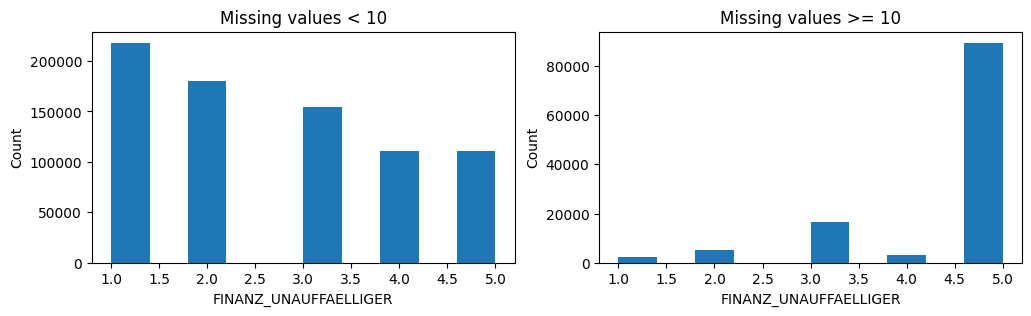

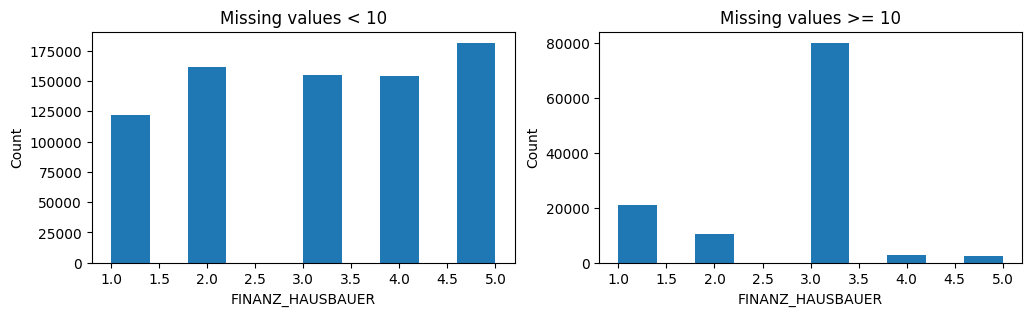

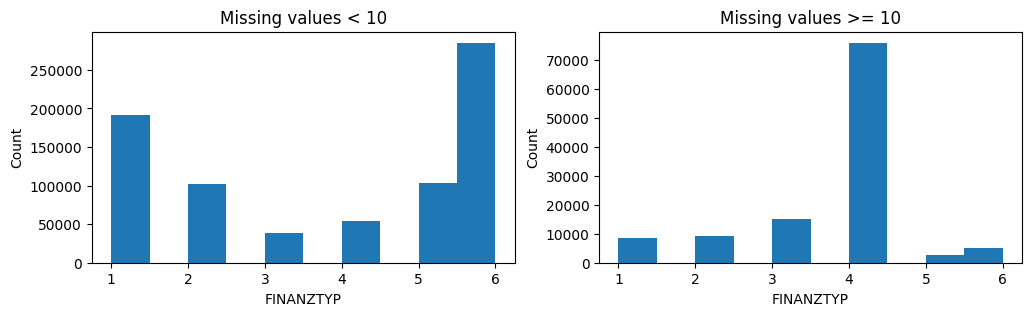

In [26]:
for i in range(len(comparing_columns)):
    create_comparison_plot(comparing_columns[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row

Comparing the columns leads to the following observation: The picture is different - on the one hand side we have categories like ALTERSKATEGORIE GROB and ANREDE_KZ with a very similar distribution - those were rows we could drop. On the other hand we have several columns with different distributions - upmost financial categories.
I think there should be a deeper analytical step included for all categories.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# How many features are there of each data type?
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [28]:
# Finding a way to show only the features that are in our dataset (5 were already dropped)
feature_attr = feat_info[feat_info['attribute'].isin(missing_row_values_lt10.columns)]
feature_attr

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


In [29]:
# Counting the number of each feature type
feature_attr['type'].value_counts()

type
ordinal        49
categorical    18
mixed           6
numeric         6
Name: count, dtype: int64

**Finding**: <br>
Lets start with the 18 categorical features.

In [30]:
# Overview of the categorical features
feat_info[feat_info.type == 'categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
# Assess categorical variables: which are two_level, which are multi-level, and
# which one needs to be re-encoded?
multi_level, two_level = [], []

# Checking the feat_info for 'categorical' and taking the attributes name as a counter
for column in feat_info[feat_info.type == 'categorical']['attribute']:
    if column in missing_row_values_lt10: # Some columns have been dropped already :)
        # Two-Level features have only two counts, multi-level more than two
        if missing_row_values_lt10[column].nunique() > 2:
            multi_level.append(column)
        else:
            two_level.append(column)
            
print(f'Multi-Level Columns: {multi_level}')
print(f'Two-level Columns: {two_level}')

Multi-Level Columns: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Two-level Columns: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [32]:
# Checking the values in the two_level categoricals - especially because of the one non-numeric
for columns in two_level:
    print(missing_row_values_lt10[columns].value_counts())

ANREDE_KZ
2    403812
1    370931
Name: count, dtype: int64
GREEN_AVANTGARDE
0    604274
1    170469
Name: count, dtype: int64
SOHO_KZ
0.0    768249
1.0      6494
Name: count, dtype: int64
VERS_TYP
2.0    387236
1.0    354087
Name: count, dtype: int64
OST_WEST_KZ
W    610258
O    164485
Name: count, dtype: int64


**Finding**: <br>
Looking at the binary columns we can see, that 'OST_WEST_KZ' has non-numerical values. These need to be re-encoded.

In [33]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Re-encoding OST_WEST_KZ
missing_row_values_lt10.loc[:, 'OST_WEST_KZ'] = missing_row_values_lt10.loc[:, 'OST_WEST_KZ'].replace({'W': 0, 'O': 1})

**Finding**: <br>To go straightforward, i drop the multi-level categories. Alternatively we could one-hote-encoding them with pd.get_dummies(missing_row_values_lt10, columns = multi_level). Lets wait for the result, perhaps we need them later on.

In [34]:
# Dropping the multi_level features
missing_row_values_lt10 = missing_row_values_lt10.drop(columns = multi_level, axis = 1)

#### Discussion 1.2.1: Re-Encode Categorical Features

With a view to the categorical features: There were 18 categorical features, 5 of them two-level and 13 multi-level. 
Only one of the two-level features had to be re_encoded: OST_WEST_KZ, because it was non-numerical. 
To go straightforward and risking computational cost because of more variables i dropped the multi-level features - depending on the end-result and customer wishes it is possible to add them later on.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
# Checking feat_info for the 'mixed' features
feat_info[feat_info.type == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


**From Data_Dictionary.md:**

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

I try the following keys for the Decades:
<ul>
    <li>1: 40s
    <li>2: 50s
    <li>3: 60s
    <li>4: 70s
    <li>5: 80s
    <li>6: 90s
</ul>

and the following for movement:

<ul>
    <li>1: Mainstream
    <li>2: Avantgarde
</ul>

In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# working with two dictionaries - one for the decade and one for the movement.

# Creating a dictionary for decades - taking the keys as defined above:
decade_dict = {1: 1, 2: 1,                   # 40s
               3: 2, 4: 2,                   # 50s
               5: 3, 6: 3, 7: 3,             # 60s
               8: 4, 9: 4,                   # 70s
               10: 5, 11: 5, 12: 5, 13: 5,   # 80s
               14: 6, 15: 6}                 # 90s

missing_row_values_lt10['DECADES'] = missing_row_values_lt10['PRAEGENDE_JUGENDJAHRE'].replace(decade_dict)
missing_row_values_lt10.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0


In [37]:
# Creating a dictionary for movements - taking the keys as defined above
movement_dict = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,                 # Mainstream
                 2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2}           # Avantgarde

missing_row_values_lt10['MOVEMENT'] = missing_row_values_lt10['PRAEGENDE_JUGENDJAHRE'].replace(movement_dict)
missing_row_values_lt10.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENT
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0


In [38]:
# Dropping the 'PRAEGENDE_JUGENDJAHRE' column
missing_row_values_lt10 = missing_row_values_lt10.drop(columns = 'PRAEGENDE_JUGENDJAHRE', axis = 1)
missing_row_values_lt10.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENT
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0


**From Data_Dictionary.md:**

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

I try the following keys for the wealth stage:
<ul>
    <li>1: Wealthy Households
    <li>2: Prosperous Households
    <li>3: Comfortable Households
    <li>4: Less Affluent Households
    <li>5: Poorer Households
</ul>

In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Creating a dictionary for the wealth stage - as defined above
wealth_stage_dict = {'11': 1, '12': 1, '13': 1, '14': 1, '15': 1,    # Wealthy Households
                    '21': 2, '22': 2, '23': 2, '24': 2, '25': 2,     # Prosperous Households
                    '31': 3, '32': 3, '33': 3, '34': 3, '35': 3,     # Comfortable Households
                    '41': 4, '42': 4, '43': 4, '44': 4, '45': 4,     # Less Affluent Households
                    '51': 5, '52': 5, '53': 5, '54': 5, '55': 5      # Poorer Households
                    }

missing_row_values_lt10['WEALTH_STAGE'] = missing_row_values_lt10['CAMEO_INTL_2015'].replace(wealth_stage_dict)
missing_row_values_lt10.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENT,WEALTH_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0


I try the following keys for the life stage:
<ul>
    <li>1: Pre-Family Couples & Singles
    <li>2: Young Couples With Children
    <li>3: Families With School Age Children
    <li>4: Older Families & Mature Couples
    <li>5: Elders In Retirement
</ul>

In [40]:
# Creating a dictionary for the life_stage as defined above
life_stage_dict = {'11': 1, '21': 1, '31': 1, '41': 1, '51': 1,   # Pre-Family Couples & Singles
                   '12': 2, '22': 2, '32': 2, '42': 2, '52': 2,   # Young Couples With Children
                   '13': 3, '23': 3, '33': 3, '43': 3, '53': 3,   # Families With School Age Children
                   '14': 4, '24': 4, '34': 4, '44': 4, '54': 4,   # Older Families & Mature Couples
                   '15': 5, '25': 5, '35': 5, '45': 5, '55': 5    # Elders In Retirement
                    }

missing_row_values_lt10['LIFE_STAGE'] = missing_row_values_lt10['CAMEO_INTL_2015'].replace(life_stage_dict)
missing_row_values_lt10.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENT,WEALTH_STAGE,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [41]:
# Dropping the 'CAMEO_INTL_2015' column
missing_row_values_lt10 = missing_row_values_lt10.drop(columns = 'CAMEO_INTL_2015', axis = 1)
missing_row_values_lt10.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENT,WEALTH_STAGE,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

Phew. Okay, i think this is a part i could do more with code, especially with loops as long as the data has a pattern underneath like the wealth and life stage. So i set up four new features out of 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' with some sort of Translation-list. This is important for later, if the results depend on these values - we can draw conclusions from that. 

Due to computational cost i would like to drop the rest of the mixed features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [42]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

feat_info[feat_info.type == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [43]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Dropping the rest of the 'mixed' features:
for feature in feat_info[feat_info.type == 'mixed'].attribute:
    if feature in missing_row_values_lt10:
        missing_row_values_lt10 = missing_row_values_lt10.drop(columns = feature, axis = 1)

missing_row_values_lt10.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENT,WEALTH_STAGE,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [44]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    multi_level = []

    decade_dict = {1: 1, 2: 1,                   # 40s
                   3: 2, 4: 2,                   # 50s
                   5: 3, 6: 3, 7: 3,             # 60s
                   8: 4, 9: 4,                   # 70s
                   10: 5, 11: 5, 12: 5, 13: 5,   # 80s
                   14: 6, 15: 6                  # 90s
                  }
    
    movement_dict = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,                 # Mainstream
                     2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2            # Avantgarde
                    }
    
    wealth_stage_dict = {'11': 1, '12': 1, '13': 1, '14': 1, '15': 1,    # Wealthy Households
                         '21': 2, '22': 2, '23': 2, '24': 2, '25': 2,     # Prosperous Households
                         '31': 3, '32': 3, '33': 3, '34': 3, '35': 3,     # Comfortable Households
                         '41': 4, '42': 4, '43': 4, '44': 4, '45': 4,     # Less Affluent Households
                         '51': 5, '52': 5, '53': 5, '54': 5, '55': 5      # Poorer Households
                        }
    
    life_stage_dict = {'11': 1, '21': 1, '31': 1, '41': 1, '51': 1,   # Pre-Family Couples & Singles
                       '12': 2, '22': 2, '32': 2, '42': 2, '52': 2,   # Young Couples With Children
                       '13': 3, '23': 3, '33': 3, '43': 3, '53': 3,   # Families With School Age Children
                       '14': 4, '24': 4, '34': 4, '44': 4, '54': 4,   # Older Families & Mature Couples
                       '15': 5, '25': 5, '35': 5, '45': 5, '55': 5    # Elders In Retirement
                      }
    
    df_clean = df
    
    # Replacing all missing values with NaN
    list_of_missing_values = []

    for values in feat_info['missing_or_unknown']:
        list_of_missing_values.append(values[1:-1].split(',')) # splitting the data and eliminating []
    
    for i in range(len(feat_info)):
        if list_of_missing_values[i] != ['']: #important step, because there are columns without missing values.
        
            # Converting the values to integer (with a view of the 'X' and 'XX' values in feat_info
            list_of_missing_values[i] = [value if (value == 'X' or value == 'XX') else int(value) for value in list_of_missing_values[i]]
            # Replacing the attributes equal to the list of missing values with NaN
            df_clean = df_clean.replace({feat_info.iloc[i]['attribute']: list_of_missing_values[i]}, np.nan)

            
    # Removing columns with more than 30% of missing values
    drop_columns = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df_clean = df_clean.drop(columns = drop_columns, axis = 1)
    
    # Removing rows with more than 10 missing values
    missing_values_row = df_clean.isna().sum(axis = 1)
    df_clean = df_clean[missing_values_row < 10]
        
    # Re-encoding OST_WEST_KZ - binary feature
    df_clean.loc[:, 'OST_WEST_KZ'] = df_clean.loc[:, 'OST_WEST_KZ'].replace({'W': 0, 'O': 1})
    
    # Checking the multi-leve categorical features and drop them
    for column in feat_info[feat_info.type == 'categorical'].attribute:
        if column in df_clean: # Some columns have been dropped already :)
            if df_clean[column].nunique() > 2:
                multi_level.append(column)
    df_clean = df_clean.drop(columns = multi_level, axis = 1)
    
    # Mixed Features
    # Re-Encoding 'PRAEGENDE_JUGENDJAHRE'
    df_clean['DECADES'] = df_clean['PRAEGENDE_JUGENDJAHRE'].replace(decade_dict)
    df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE'].replace(movement_dict)
    
    #Re-Encoding 'CMAEO_INTL_2015'
    df_clean['WEALTH_STAGE'] = df_clean['CAMEO_INTL_2015'].replace(wealth_stage_dict)
    df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015'].replace(life_stage_dict)
    
    # Dropping the 'mixed' features:
    for feature in feat_info[feat_info.type == 'mixed'].attribute:
        if feature in df_clean:
            df_clean = df_clean.drop(columns = feature, axis = 1)
    
    # Return the cleaned dataframe.
    
    return df_clean
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [45]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Replacing all missing values 'NaN' with the mean with SimpleImputer
imp_mean = SimpleImputer(missing_values = np.nan, strategy = "mean")
df_impute = pd.DataFrame(imp_mean.fit_transform(missing_row_values_lt10))
df_impute.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.000000,9.0,11.0,0.0,1.0,1992.0,0.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.000000,1.0,3.0,3.000000,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.000000,9.0,10.0,0.0,5.0,1992.0,0.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.000000,3.0,2.0,2.000000,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,4.176172,9.0,1.0,0.0,4.0,1997.0,0.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,2.725434,4.0,1.0,4.475896,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,4.0,0.0,5.0,2.000000,9.0,3.0,0.0,4.0,1992.0,0.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.000000,3.0,5.0,5.000000,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,2.0,1.0,0.0,5.0,6.000000,9.0,5.0,0.0,5.0,1992.0,0.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.000000,4.0,1.0,5.000000,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [46]:
df_impute.columns = missing_row_values_lt10.columns
#df_impute.index = missing_row_values_lt10.index
df_impute.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENT,WEALTH_STAGE,LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.000000,9.0,11.0,0.0,1.0,1992.0,0.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.000000,1.0,3.0,3.000000,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.000000,9.0,10.0,0.0,5.0,1992.0,0.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.000000,3.0,2.0,2.000000,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,4.176172,9.0,1.0,0.0,4.0,1997.0,0.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,2.725434,4.0,1.0,4.475896,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,4.0,0.0,5.0,2.000000,9.0,3.0,0.0,4.0,1992.0,0.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.000000,3.0,5.0,5.000000,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,2.0,1.0,0.0,5.0,6.000000,9.0,5.0,0.0,5.0,1992.0,0.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.000000,4.0,1.0,5.000000,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [47]:
# Apply feature scaling to the general population demographics data.

#Scaling the features
scaler = StandardScaler()
df_impute_scale = pd.DataFrame(scaler.fit_transform(df_impute))
df_impute_scale.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,-1.765007,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.077799,-1.676217,0.433813,-0.057065,0.006223,-0.454567,-1.685272,-1.119340,-1.436264,-0.582872,1.276931,-0.306598,1.335425,-0.157807,1.505587,1.289283,10.876643,0.977557,0.229518,-0.060656,1.011072,-6.880550e-01,0.55372,0.162817,-0.126219,-1.299669,-0.390920,-0.519166,-1.080542,-1.032214,-0.626606,2.692353,-1.648272,0.848099,-0.552862,1.704273,-0.797039,-7.680933e-01,-1.395259,0.180081,-8.338649e-01,1.017971,-0.260779,0.215354,0.410701,0.414545,1.432085,0.560706,-0.175332,-0.133626,0.679067,1.168230,-0.551870,1.179748,-1.259894
1,0.199492,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.077799,-0.303125,-0.080896,-1.628585,-0.517541,-0.454567,-0.137222,-0.167519,0.752395,-0.582872,0.068435,1.408286,1.335425,1.446075,-0.632701,-0.411312,-0.091940,-1.069074,-0.633695,-0.060656,-0.285966,-6.880550e-01,0.55372,0.099072,-0.126219,1.282406,-0.390920,-0.519166,-0.357207,1.414525,0.375186,-0.486830,-0.119737,-0.982235,0.029365,-0.266323,0.287784,-7.680933e-01,0.026822,-0.462880,-1.398854e+00,0.275729,0.772929,0.215354,-0.607739,-0.967205,0.399744,0.560706,-0.175332,-0.133626,-0.796120,1.168230,1.873696,-0.871766,0.760743
2,1.181742,0.958422,0.689233,-0.478302,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.276069,-0.989671,0.433813,-1.628585,-1.041304,-1.499368,-0.137222,-0.167519,1.299560,-0.072194,-0.535813,-0.306598,-0.309014,0.376820,-0.098129,0.155553,-0.091940,-1.069074,-1.496909,-0.060656,-2.231523,-5.195803e-16,0.55372,-0.474636,-0.126219,0.636887,1.587153,-0.519166,1.812800,-0.216634,-0.626606,-0.486830,0.644530,-0.067068,-1.135090,0.718975,0.287784,-1.410611e-15,0.737863,-1.105842,5.018109e-16,-0.067299,-0.260779,-0.876534,0.410701,-0.967205,-0.632597,0.560706,-1.180995,-1.004475,-0.058527,-0.226391,-0.551870,-1.555604,-0.586348
3,0.199492,-1.043381,0.689233,0.194471,0.407498,-1.247929,0.263375,-0.818216,-0.531136,1.077799,1.069967,0.948521,-0.057065,0.006223,-0.976968,1.410828,-0.167519,-0.341935,0.949161,-1.140061,-0.878225,-1.405307,-1.227061,-0.098129,-0.978176,-0.091940,0.977557,1.955945,-0.060656,0.362553,-1.273050e+00,0.55372,-0.347145,-0.126219,0.636887,-0.390920,-0.519166,-0.357207,2.230104,0.375186,-0.486830,-0.119737,-0.982235,0.611592,-1.744270,1.372607,2.907115e-01,0.026822,1.466005,2.961129e-01,-0.543399,-0.260779,1.307241,0.410701,0.414545,-0.632597,-0.343393,0.830331,0.301799,1.416660,-0.226391,-0.551870,0.495910,0.087197
4,-1.765007,0.958422,-0.036773,-1.151076,1.133590,-0.568811,-0.454293,1.327209,-0.531136,1.077799,-0.303125,-1.110313,-0.057065,1.577514,0.067833,-1.169255,-1.119340,-1.436264,0.438484,1.881179,-0.306598,-0.309014,-0.157807,1.505587,1.289283,-0.091940,0.977557,-0.633695,-0.060656,0.362553,1.066931e+00,0.55372,-0.219655,-0.126219,1.282406,-0.390920,-0.519166,0.366129,0.598945,-0.626606,-0.486830,0.644530,0.848099,-1.135090,1.211624,0.287784,1.349516e+00,0.737863,-1.105842,2.961129e-01,2.014527,-0.260779,0.215354,-0.607739,0.414545,1.432085,1.464805,-1.180995,-1.004475,-0.058527,-1.621012,-0.551870,1.179748,0.760743


In [48]:
df_impute_scale.columns = missing_row_values_lt10.columns
#df_impute_scale.index = missing_row_values_lt10.index
df_impute_scale.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENT,WEALTH_STAGE,LIFE_STAGE
0,-1.765007,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.077799,-1.676217,0.433813,-0.057065,0.006223,-0.454567,-1.685272,-1.119340,-1.436264,-0.582872,1.276931,-0.306598,1.335425,-0.157807,1.505587,1.289283,10.876643,0.977557,0.229518,-0.060656,1.011072,-6.880550e-01,0.55372,0.162817,-0.126219,-1.299669,-0.390920,-0.519166,-1.080542,-1.032214,-0.626606,2.692353,-1.648272,0.848099,-0.552862,1.704273,-0.797039,-7.680933e-01,-1.395259,0.180081,-8.338649e-01,1.017971,-0.260779,0.215354,0.410701,0.414545,1.432085,0.560706,-0.175332,-0.133626,0.679067,1.168230,-0.551870,1.179748,-1.259894
1,0.199492,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.077799,-0.303125,-0.080896,-1.628585,-0.517541,-0.454567,-0.137222,-0.167519,0.752395,-0.582872,0.068435,1.408286,1.335425,1.446075,-0.632701,-0.411312,-0.091940,-1.069074,-0.633695,-0.060656,-0.285966,-6.880550e-01,0.55372,0.099072,-0.126219,1.282406,-0.390920,-0.519166,-0.357207,1.414525,0.375186,-0.486830,-0.119737,-0.982235,0.029365,-0.266323,0.287784,-7.680933e-01,0.026822,-0.462880,-1.398854e+00,0.275729,0.772929,0.215354,-0.607739,-0.967205,0.399744,0.560706,-0.175332,-0.133626,-0.796120,1.168230,1.873696,-0.871766,0.760743
2,1.181742,0.958422,0.689233,-0.478302,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.276069,-0.989671,0.433813,-1.628585,-1.041304,-1.499368,-0.137222,-0.167519,1.299560,-0.072194,-0.535813,-0.306598,-0.309014,0.376820,-0.098129,0.155553,-0.091940,-1.069074,-1.496909,-0.060656,-2.231523,-5.195803e-16,0.55372,-0.474636,-0.126219,0.636887,1.587153,-0.519166,1.812800,-0.216634,-0.626606,-0.486830,0.644530,-0.067068,-1.135090,0.718975,0.287784,-1.410611e-15,0.737863,-1.105842,5.018109e-16,-0.067299,-0.260779,-0.876534,0.410701,-0.967205,-0.632597,0.560706,-1.180995,-1.004475,-0.058527,-0.226391,-0.551870,-1.555604,-0.586348
3,0.199492,-1.043381,0.689233,0.194471,0.407498,-1.247929,0.263375,-0.818216,-0.531136,1.077799,1.069967,0.948521,-0.057065,0.006223,-0.976968,1.410828,-0.167519,-0.341935,0.949161,-1.140061,-0.878225,-1.405307,-1.227061,-0.098129,-0.978176,-0.091940,0.977557,1.955945,-0.060656,0.362553,-1.273050e+00,0.55372,-0.347145,-0.126219,0.636887,-0.390920,-0.519166,-0.357207,2.230104,0.375186,-0.486830,-0.119737,-0.982235,0.611592,-1.744270,1.372607,2.907115e-01,0.026822,1.466005,2.961129e-01,-0.543399,-0.260779,1.307241,0.410701,0.414545,-0.632597,-0.343393,0.830331,0.301799,1.416660,-0.226391,-0.551870,0.495910,0.087197
4,-1.765007,0.958422,-0.036773,-1.151076,1.133590,-0.568811,-0.454293,1.327209,-0.531136,1.077799,-0.303125,-1.110313,-0.057065,1.577514,0.067833,-1.169255,-1.119340,-1.436264,0.438484,1.881179,-0.306598,-0.309014,-0.157807,1.505587,1.289283,-0.091940,0.977557,-0.633695,-0.060656,0.362553,1.066931e+00,0.55372,-0.219655,-0.126219,1.282406,-0.390920,-0.519166,0.366129,0.598945,-0.626606,-0.486830,0.644530,0.848099,-1.135090,1.211624,0.287784,1.349516e+00,0.737863,-1.105842,2.961129e-01,2.014527,-0.260779,0.215354,-0.607739,0.414545,1.432085,1.464805,-1.180995,-1.004475,-0.058527,-1.621012,-0.551870,1.179748,0.760743


In [49]:
df_impute_scale.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENT,WEALTH_STAGE,LIFE_STAGE
count,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05
mean,4.109859e-16,-3.738236e-17,-1.041864e-16,8.767796e-17,4.510462e-17,1.162742e-16,-3.250321e-17,1.707152e-16,6.704246e-17,-1.091389e-17,6.086556e-17,-1.918643e-17,-1.108631e-16,-5.389076e-17,-1.366529e-17,-2.318147e-16,2.105922e-16,1.533814e-16,9.308905e-17,-9.325413e-17,1.955695e-16,3.067811e-17,-7.171067e-17,1.166594e-16,1.504099e-17,4.519634e-17,1.426326e-16,-2.430404e-17,-1.588475e-17,1.742003e-16,-4.735160e-16,6.772114e-17,1.225841e-16,-7.153641e-17,-9.518928e-17,-1.865633e-14,5.502801e-17,-8.595375e-17,-1.745195e-15,8.700845e-17,-5.389076e-17,-7.188125e-16,-2.245464e-15,-1.150269e-16,-4.630699e-16,-1.369280e-16,-1.464185e-15,-1.577470e-18,3.705219e-17,5.024057e-16,1.658177e-17,-2.971512e-18,-5.066062e-16,4.899327e-16,-2.038604e-16,1.883682e-15,-1.522808e-16,2.280691e-15,-5.020389e-17,5.251506e-16,-9.273320e-16,-1.465350e-15,-8.260438e-16,4.032086e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.765007e+00,-1.043381e+00,-1.488785e+00,-1.151076e+00,-1.770775e+00,-1.247929e+00,-1.171961e+00,-1.533358e+00,-5.311360e-01,-1.629936e+00,-1.676217e+00,-1.625021e+00,-1.628585e+00,-1.565068e+00,-1.499368e+00,-1.685272e+00,-1.595251e+00,-1.983429e+00,-1.604228e+00,-1.744309e+00,-2.021481e+00,-1.953454e+00,-1.761688e+00,-1.701844e+00,-1.545041e+00,-9.194014e-02,-1.069074e+00,-1.496909e+00,-6.065581e-02,-2.231523e+00,-1.858046e+00,-3.667443e+00,-4.746359e-01,-1.262189e-01,-1.299669e+00,-3.160224e+00,-5.191662e-01,-1.080542e+00,-1.032214e+00,-6.266065e-01,-4.868305e-01,-1.648272e+00,-1.439818e+00,-1.717317e+00,-1.744270e+00,-2.966685e+00,-1.826898e+00,-1.3

### Discussion 2.1: Apply Feature Scaling

I used as suggested the SimpleImputer for replaciong all the missing values and hold 'mean' as a filling method along each column. And as a second step i used the StandardScaler to scale the features so it looks normally distributed and a later ML algorithm can handle it better. 


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [50]:
# Apply PCA to the data.
pca = PCA(random_state = random_state)
pca.fit(df_impute_scale)

PCA(random_state=2250)

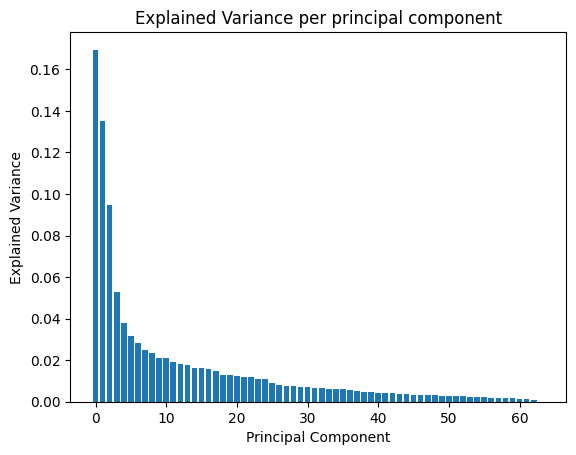

In [51]:
# Investigate the variance accounted for by each principal component.
variances = pca.explained_variance_ratio_
num_components = np.arange(len(variances))

plt.bar(num_components, variances)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance per principal component')

plt.show()

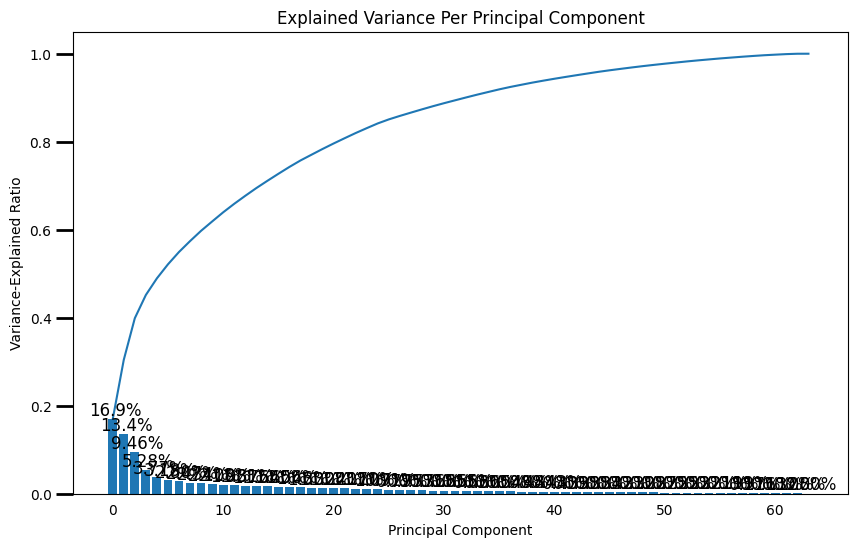

In [52]:
# From the helper functions of the lessons before
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance-Explained Ratio")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

In [53]:
# Calculating the number of components with a variance greater than 0.85
variance_sum = 0
for num_comp in num_components:
    variance_sum += variances[num_comp]
    if variance_sum > 0.85:
        print(f'With {num_comp} components we can explain {variance_sum} variance.')
        break

With 25 components we can explain 0.8507378531676635 variance.


In [54]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_refit = PCA(n_components = num_comp, random_state = random_state)
df_pca_refit = pca_refit.fit_transform(df_impute_scale)

### Discussion 2.2: Perform Dimensionality Reduction

As we can see with 25 components we are able to explain 85% of variance. I think this is a good choice, because we use around 32% of the original features for a high variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [55]:
# Defining a function for the weights of the i-th component
def pca_weights(df, pca, num_comp):
    """
    This function gives out the sorted weights of a given pca-analysis for a principal component
    
    INPUT:
    df: DataFrame for the column_names
    pca: The pca of the PCA-Analysis
    num_comp: Number of Principal component
    
    OUTPUT:
    weights: Sorted Dataframe of weights 
    """
    weights = pd.DataFrame(pca.components_, columns = df.columns)
    weights = weights.iloc[num_comp].sort_values(ascending = False)
    
    return weights

# Defining a chart with a view at the top and bottom of the list (to prevent to much scrolling)
def plot_weights(weights, numcount):
    """
    This function plots a bar chart with numcount parts from the top and the bottom
    
    INPUT:
    weights: the weights of a pca
    numcount: the number of weights to show
    
    OUTPUT:
    A DataFrame-Plot
    """
    top_bottom_numcount = pd.concat([weights.head(numcount), weights.tail(numcount)])
    top_bottom_numcount.plot(kind = 'bar')
    plt.show()

In [56]:
pca_weight = []

In [57]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pca_weight.append(pca_weights(df_impute_scale, pca_refit, 0))
pca_weight[0]

PLZ8_ANTG3               0.226896
PLZ8_ANTG4               0.220022
WEALTH_STAGE             0.207763
HH_EINKOMMEN_SCORE       0.204404
ORTSGR_KLS9              0.197647
EWDICHTE                 0.195882
FINANZ_HAUSBAUER         0.163104
PLZ8_ANTG2               0.154412
KBA05_ANTG4              0.153162
FINANZ_SPARER            0.144062
ARBEIT                   0.144023
ANZ_HAUSHALTE_AKTIV      0.135892
RELAT_AB                 0.135711
KBA05_ANTG3              0.135498
SEMIO_PFLICHT            0.112661
SEMIO_REL                0.109925
DECADES                  0.099320
SEMIO_RAT                0.092645
SEMIO_TRADV              0.086248
SEMIO_MAT                0.077496
SEMIO_FAM                0.076399
REGIOTYP                 0.073111
FINANZ_UNAUFFAELLIGER    0.072536
SEMIO_KULT               0.070538
FINANZ_ANLEGER           0.067054
OST_WEST_KZ              0.053941
KKK                      0.044147
SEMIO_SOZ                0.041938
PLZ8_HHZ                 0.041642
SEMIO_KAEM    

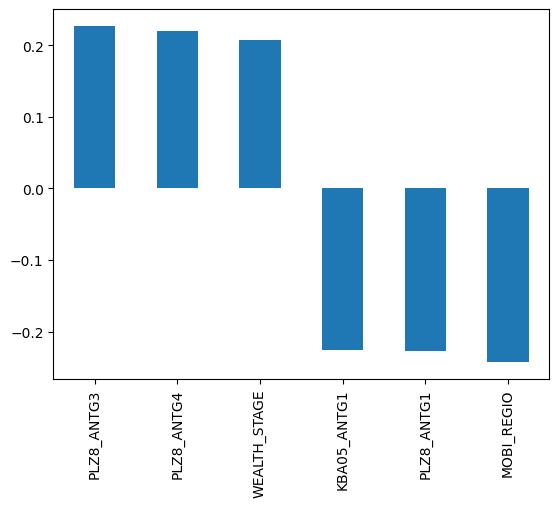

In [58]:
plot_weights(pca_weight[0], 3)

**Finding**: <br>
Interpretation:<br>
Lets take a look at the Data_Dictionary for these values:
<ul>
    <li>PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region
    <li>PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region
    <li>WEALTH_STAGE: Wealth-Stage typology
    <li>
    <li>KBA05_ANTG1: Number of 1-2 family houses in the microcell
    <li>PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region
    <li>MOBI_REGIO: Movement patterns
</ul>
It seems that the first component has great influences by big houses in the PLZ8 region and the wealth_state. <br>
There is a negative association with small homes in microcells and their movement_patterns.

In [59]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight.append(pca_weights(df_impute_scale, pca_refit, 1))
pca_weight[1]

ALTERSKATEGORIE_GROB     0.260516
FINANZ_VORSORGER         0.233151
SEMIO_ERL                0.230804
SEMIO_LUST               0.183093
RETOURTYP_BK_S           0.164550
W_KEIT_KIND_HH           0.118499
SEMIO_KRIT               0.116387
FINANZ_HAUSBAUER         0.114728
SEMIO_KAEM               0.111380
PLZ8_ANTG3               0.091052
ANREDE_KZ                0.089792
EWDICHTE                 0.089585
ORTSGR_KLS9              0.088144
PLZ8_ANTG4               0.086940
WEALTH_STAGE             0.071861
SEMIO_DOM                0.069265
FINANZ_MINIMALIST        0.068622
KBA05_ANTG4              0.067370
ARBEIT                   0.065458
RELAT_AB                 0.063125
PLZ8_ANTG2               0.062766
ANZ_HAUSHALTE_AKTIV      0.061039
WOHNDAUER_2008           0.059743
HH_EINKOMMEN_SCORE       0.052603
KBA05_ANTG3              0.041585
VERS_TYP                 0.032763
ANZ_HH_TITEL             0.030588
OST_WEST_KZ              0.024870
REGIOTYP                 0.021160
PLZ8_HHZ      

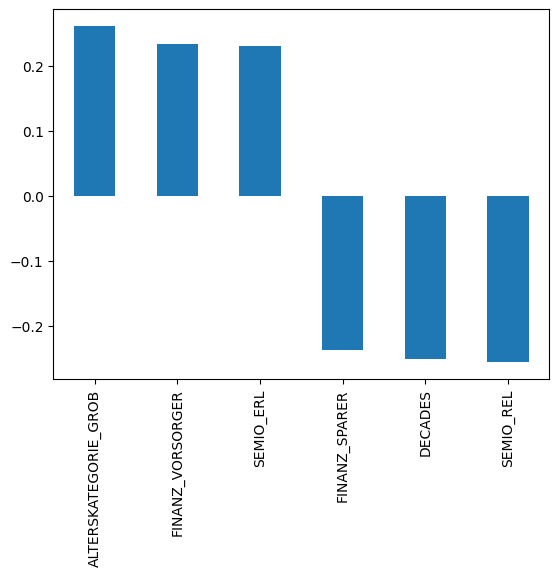

In [60]:
plot_weights(pca_weight[1], 3)

**Finding**: <br>
Interpretation:<br>
Lets take a look at the Data_Dictionary for these values:
<ul>
    <li>ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
    <li>FINANZ_VORSORGER: Financial typology - VORSORGER: be prepared
    <li>SEMIO_ERL: Personality typology - ERL: event-oriented
    <li>
    <li>FINANZ_SPARER: Financial typology - SPARER: money-saver
    <li>DECADES: Dominating decade of youth
    <li>SEMIO_REL: Personality typology - REL: religious
</ul>
The second component is vastly influenced by some personal typology like prepared and event-oriented human. And it highly depends on the estimated age of someone.<br>
The negative influence is more like a stable money-saver and religious person, influenced by the decade of youth.

In [61]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight.append(pca_weights(df_impute_scale, pca_refit, 2))
pca_weight[2]


SEMIO_VERT               0.346328
SEMIO_SOZ                0.263369
SEMIO_FAM                0.250307
SEMIO_KULT               0.234272
FINANZ_MINIMALIST        0.156331
RETOURTYP_BK_S           0.109321
FINANZ_VORSORGER         0.100307
W_KEIT_KIND_HH           0.090614
ALTERSKATEGORIE_GROB     0.078779
SEMIO_REL                0.070500
SEMIO_LUST               0.064319
SEMIO_MAT                0.054793
GREEN_AVANTGARDE         0.048282
ORTSGR_KLS9              0.046631
MOVEMENT                 0.046509
EWDICHTE                 0.046135
PLZ8_ANTG4               0.045486
PLZ8_ANTG3               0.045074
ARBEIT                   0.034314
WOHNDAUER_2008           0.032690
RELAT_AB                 0.031412
PLZ8_ANTG2               0.030147
KBA05_ANTG4              0.027047
WEALTH_STAGE             0.026901
ANZ_HAUSHALTE_AKTIV      0.025280
VERS_TYP                 0.014881
OST_WEST_KZ              0.014800
ANZ_HH_TITEL             0.013233
ANZ_TITEL                0.009768
KBA05_ANTG3   

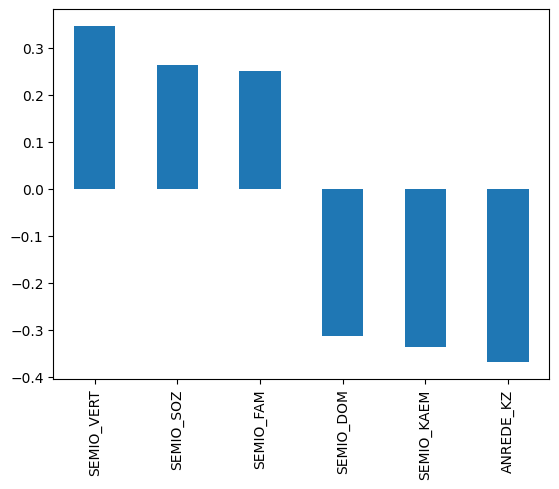

In [62]:
plot_weights(pca_weight[2], 3)

**Finding**: <br>
Interpretation:<br>
Lets take a look at the Data_Dictionary for these values:
<ul>
    <li>SEMIO_VERT: Personality typology - VERT: dreamful
    <li>SEMIO_SOZ: Personality typology - SOZ: socially-minded
    <li>SEMIO_FAM: Personality typology - FAM: family-minded
    <li>
    <li>SEMIO_DOM: Personality typology - DOM: dominant-minded
    <li>SEMIO_KAEM: Personality typology - KAEM: combative attitude
    <li>ANREDE_KZ: Gender
</ul>
The third component has a strong influence by dreamful, socially and family-minded persons. Sounds like very peaceful. <br>
At the opposite corner standing the dominant-minded and combative attitude, and the gender. Thats quite interesting, so its genderneutral.

### Discussion 2.3: Interpret Principal Components

Overall we can see some good relations and a great overview for the first three components:
The first component seems to correlate to the density around and financial status of someone.
The second component is described by people who want to experience things.
The third component is personality driven, with a big influene of soft skilling typologies.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [63]:
# From the lesson of K-Means:

def get_kmeans_score(data, center):
    """
    The function returns the kmeans score regarding SSE for points to centers
    
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
        
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    """
    kmeans = KMeans(n_clusters = center, random_state = random_state)

    model = kmeans.fit(data)
    
    score = np.abs(model.score(data))
    
    return score

In [64]:
# Calculating a score for a batch of centroids to analyse the best number of clusters
scores = []
centroids = list(range(1,21))

for centroid in centroids:
    scores.append(get_kmeans_score(df_pca_refit, centroid))
    print(f'{centroid} centroid(s) calculated.')

1 centroid(s) calculated.
2 centroid(s) calculated.
3 centroid(s) calculated.
4 centroid(s) calculated.
5 centroid(s) calculated.
6 centroid(s) calculated.
7 centroid(s) calculated.
8 centroid(s) calculated.
9 centroid(s) calculated.
10 centroid(s) calculated.
11 centroid(s) calculated.
12 centroid(s) calculated.
13 centroid(s) calculated.
14 centroid(s) calculated.
15 centroid(s) calculated.
16 centroid(s) calculated.
17 centroid(s) calculated.
18 centroid(s) calculated.
19 centroid(s) calculated.
20 centroid(s) calculated.


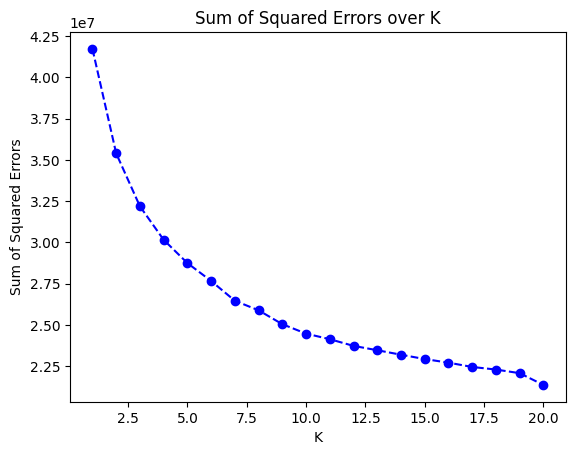

In [65]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Plotting the Squared Errors over K number of clusters to find the elbow:
plt.plot(centroids, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Sum of Squared Errors');
plt.title('Sum of Squared Errors over K');

**Finding**: <br>
Interesting plot - not exactly an elbow, but i assume that with k = 7 we have a good number of clusters. There could be somewhat like an elbow, where the slope changes significantly.

In [66]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Defining the number of clusters
num_cluster = 7

# Setting up and fitting the kemans algorithm with the found pca's
kmeans = KMeans(n_clusters = num_cluster, random_state = random_state)
refit_model = kmeans.fit(df_pca_refit)

# predicting the clusters for the general data
azdias_pred = refit_model.predict(df_pca_refit)

### Discussion 3.1: Apply Clustering to General Population

I have decided to cluster the population into 7 clusters depending on the elbow-method and the given plot before. Interesting is, that the plot is not like in theory :) Looking at the plot, at k=7 is in my opionion the best point wehre one can see a change in the slope.<br>
Interesting is the change from cluster 19 to 20 - perhaps this could be point to investigate afterwards.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [67]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [68]:
customers.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,1,3,1,4.0,5,1,5,1,2,3,5,0,11.0,1,3,17.0,5.0,2.0,2.0,7.0,3.0,1,4,3.0,6,4,4,1,7,6,4,6,2,5,5,3,3,4,1,0.0,0.0,2,2,11.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,2.0,1992.0,W,1.0,5,5D,34,2.0,2.0,1.0,0.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
6,2,4,1,2.0,5,1,5,1,1,2,2,1942,10.0,1,2,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,4,2,5,1,6,5,3,4,3,3,1,2,2,4,0,0.0,0.0,1,1,10.0,2.0,0.0,2.0,5.0,6.0,9.0,1.0,0.0,1.0,4.0,1992.0,W,7.0,3,3B,23,4.0,1.0,0.0,0.0,1.0,4.0,6.0,2.0,5.0,4.0,2.0,4.0,4.0,3.0,1300.0,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0
7,1,4,1,2.0,5,1,5,1,2,2,5,1938,8.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,4,5,6,7,7,3,4,1,3,3,1,1,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,5.0,6.0,9.0,1.0,0.0,1.0,3.0,1992.0,W,3.0,1,1D,15,3.0,2.0,0.0,0.0,1.0,4.0,5.0,3.0,5.0,4.0,1.0,4.0,3.0,1.0,481.0,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0
8,2,4,2,1.0,2,2,5,1,1,5,5,1914,3.0,0,2,6.0,2.0,1.0,1.0,1.0,1.0,1,1,5.0,2,3,1,1,2,7,7,1,3,7,6,6,1,1,3,0.0,0.0,2,3,5.0,1.0,0.0,6.0,4.0,6.0,3.0,74.0,2.0,3.0,1.0,1994.0,W,4.0,9,9E,55,0.0,0.0,0.0,2.0,5.0,1.0,3.0,6.0,1.0,3.0,NaN,1.0,2.0,NaN,428.0,1.0,4.0,2.0,1.0,5.0,5.0,4.0,3.0,8.0,3.0
9,1,3,1,3.0,5,2,4,1,3,1,2,1959,1.0,1,3,28.0,8.0,8.0,4.0,10.0,5.0,1,9,2.0,6,4,4,1,7,4,4,5,2,3,5,3,3,4,0,0.0,0.0,2,1,20.0,3.0,0.0,1.0,4.0,2.0,9.0,1.0,0.0,1.0,5.0,1997.0,W,5.0,1,1D,15,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,4.0,4.0,2.0,4.0,5.0,6.0,1106.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0


In [69]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Cleaning the data
cust_cleaned = clean_data(customers)

In [70]:
cust_cleaned.head(15)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENT,WEALTH_STAGE,LIFE_STAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,2.0,2.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0.0,2.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,2.0,2.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,1.0,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,1992.0,0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,0.0,2.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,3.0,6,4,4,1,7,6,4,6,2,5,5,3,3,4,0.0,2.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1992.0,0,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,5.0,5.0,3.0,7.0,5.0,2.0,2.0,3.0,4.0
6,4.0,1,5,1,5,1,1,2,1,2.0,5.0,4,2,5,1,6,5,3,4,3,3,1,2,2,4,0.0,1.0,2.0,0.0,2.0,6.0,9.0,1.0,0.0,4.0,1992.0,0,4.0,1.0,0.0,0.0,4.0,6.0,2.0,5.0,4.0,2.0,4.0,4.0,3.0,1300.0,3.0,2.0,1.0,0.0,5.0,5.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0
7,4.0,1,5,1,5,1,2,2,1,1.0,5.0,6,4,5,6,7,7,3,4,1,3,3,1,1,1,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,3.0,1992.0,0,3.0,2.0,0.0,0.0,4.0,5.0,3.0,5.0,4.0,1.0,4.0,3.0,1.0,481.0,3.0,3.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0,2.0,2.0,1.0,5.0
8,4.0,2,2,2,5,1,1,5,0,2.0,5.0,2,3,1,1,2,7,7,1,3,7,6,6,1,1,0.0,2.0,1.0,0.0,6.0,6.0,3.0,74.0,2.0,1.0,1994.0,0,0.0,0.0,0.0,2.0,1.0,3.0,6.0,1.0,3.0,NaN,1.0,2.0,NaN,428.0,1.0,4.0,2.0,1.0,5.0,4.0,3.0,8.0,3.0,1.0,1.0,5.0,5.0
9,3.0,1,5,2,4,1,3,1,1,3.0,2.0,6,4,4,1,7,4,4,5,2,3,5,3,3,4,0.0,2.0,3.0,0.0,1.0,2.0,9.0,1.0,0.0,5.0,1997.0,0,2.0,2.0,0.0,0.0,4.0,2.0,5.0,4.0,4.0,2.0,4.0,5.0,6.0,1106.0,3.0,3.0,1.0,0.0,5.0,5.0,3.0,6.0,4.0,4.0,2.0,1.0,5.0
11,4.0,1,5,1,5,1,3,2,1,1.0,5.0,6,4,5,6,7,7,3,4,3,1,3,1,4,4,0.0,1.0,1.0,0.0,1.0,6.0,3.0,1.0,0.0,1.0,1992.0,0,4.0,0.0,0.0,0.0,5.0,6.0,2.0,6.0,3.0,1.0,4.0,5.0,1.0,623.0,4.0,2.0,1.0,0.0,3.0,3.0,2.0,5.0,1.0,2.0,2.0,1.0,4.0


In [71]:
cust_cleaned.isna().sum()

ALTERSKATEGORIE_GROB      212
ANREDE_KZ                   0
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
GREEN_AVANTGARDE            0
HEALTH_TYP               2026
RETOURTYP_BK_S              0
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
SEMIO_ERL                   0
SEMIO_KULT                  0
SEMIO_RAT                   0
SEMIO_KRIT                  0
SEMIO_DOM                   0
SEMIO_KAEM                  0
SEMIO_PFLICHT               0
SEMIO_TRADV                 0
SOHO_KZ                     0
VERS_TYP                 2026
ANZ_PERSONEN                0
ANZ_TITEL                   0
HH_EINKOMMEN_SCORE          0
W_KEIT_KIND_HH           7388
WOHNDAUER_2008              0
ANZ_HAUSHALTE_AKTIV      2153
ANZ_HH_TIT

In [72]:
# Replacing NaN-values with 'mean'

#imp_mean = SimpleImputer(missing_values = np.nan, strategy = "mean")
cust_impute = pd.DataFrame(imp_mean.transform(cust_cleaned))
cust_impute.columns = cust_cleaned.columns
cust_impute.index = cust_cleaned.index
cust_impute.isna().sum().sum()

0

In [73]:
cust_impute.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENT,WEALTH_STAGE,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,1.0,6.000000,9.0,1.000000,0.000000,5.0,1992.0,0.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,2.0,2.0,1.0,3.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,1.0,0.0,2.0,1.0,0.0,1.0,6.000000,9.0,1.000000,0.000000,1.0,1992.0,0.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,2.0,2.0,3.0,4.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,3.0,6.0,5.0,3.0,4.0,7.0,5.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,0.0,1.0,0.0,0.0,4.0,4.176172,9.0,8.445815,0.041066,2.0,1992.0,0.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,5.0,4.0,5.0,4.0,6.0,5.0,6.0,4.0,5.0,5.0,3.0,5.0,2.0,5.0,4.0,0.0,2.0,4.0,0.0,6.0,2.000000,9.0,7.000000,0.000000,1.0,1992.0,0.0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,3.0,6.0,4.0,4.0,1.0,7.0,6.0,4.0,6.0,2.0,5.0,5.0,3.0,3.0,4.0,0.0,2.0,2.0,0.0,1.0,6.000000,9.0,1.000000,0.000000,2.0,1992.0,0.0,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,5.0,5.0,3.0,7.0,5.0,2.0,2.0,3.0,4.0


In [74]:
# Applying Feature Scaling

#scaler = StandardScaler()
cust_impute_scaled = pd.DataFrame(scaler.transform(cust_impute))
cust_impute_scaled.columns = cust_cleaned.columns
cust_impute_scaled.index = cust_cleaned.index
cust_impute_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENT,WEALTH_STAGE,LIFE_STAGE
0,1.181742,-1.043381,1.415239,-1.151076,1.133590,-1.247929,-0.454293,-0.818216,1.882757,-1.629936,1.069967,0.948521,0.466775,-1.041304,1.112635,0.894811,1.260213,-0.889100,-0.072194,-1.744309,-0.878225,-1.953454,-1.761688,-1.167273,-1.545041,-0.09194,-1.069074,0.229518,-0.060656,-2.231523,1.066931e+00,0.55372,-4.746359e-01,-1.262189e-01,1.282406,-0.39092,-0.519166,0.366129,0.598945,-0.626606,-0.48683,0.644530,-0.524651,-1.135090,-0.266323,0.287784,-1.826898,0.737863,0.180081,-1.963843,1.721770,0.772929,0.215354,-0.607739,-0.967205,1.432085,1.464805,-2.186657,-1.439900,-1.533713,-1.621012,1.873696,-1.555604,0.087197
2,1.181742,0.958422,1.415239,-1.151076,1.133590,-1.247929,0.981043,0.612067,1.882757,-0.276069,1.069967,-1.110313,-1.104745,-1.565068,-0.454567,-0.653239,1.260213,1.299560,-1.604228,-1.140061,1.408286,0.239132,0.911448,-0.098129,-1.545041,-0.09194,0.977557,-0.633695,-0.060656,-2.231523,1.066931e+00,0.55372,-4.746359e-01,-1.262189e-01,-1.299669,-0.39092,-0.519166,0.366129,0.598945,-0.626606,-0.48683,-0.119737,1.305682,0.029365,-1.744270,-0.797039,0.290712,0.026822,-1.105842,1.426091,-0.549313,-0.260779,0.215354,1.429142,0.414545,-0.632597,-1.247491,-0.175332,-0.133626,-0.058527,-1.621012,1.873696,-0.187928,0.760743
3,1.181742,-1.043381,1.415239,-1.151076,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.276069,-0.303125,0.948521,0.466775,-0.517541,0.067833,1.410828,0.308392,-0.889100,-0.072194,-0.535813,-0.878225,-0.857161,-0.692434,-0.632701,0.155553,-0.09194,-1.069074,-1.496909,-0.060656,-0.285966,-5.195803e-16,0.55372,1.132345e-16,-2.132693e-17,-0.654151,-0.39092,-0.519166,1.089465,-1.032214,-0.626606,-0.48683,0.644530,1.305682,-1.717317,1.211624,0.287784,0.290712,0.737863,-0.462880,0.861102,0.402886,0.772929,-0.876534,-0.607739,-0.967205,-0.632597,0.560706,-2.186657,-1.004475,-1.533713,-2.318322,-0.551870,-0.871766,0.760743
4,0.199492,-1.043381,-0.036773,-1.151076,0.407498,0.789423,1.698711,-0.818216,-0.531136,1.077799,1.069967,-0.080896,0.466775,0.006223,1.112635,0.378795,0.784302,-0.341935,0.438484,0.672683,-0.878225,0.239132,-1.227061,0.436443,0.155553,-0.09194,0.977557,1.955945,-0.060656,1.011072,-1.273050e+00,0.55372,-9.216397e-02,-1.262189e-01,-1.299669,-0.39092,-0.519166,-1.080542,1.414525,1.376978,-0.48683,-0.119737,-0.524651,0.029365,-0.266323,-0.797039,1.349516,0.026822,1.466005,1.426091,-0.312742,-0.260779,1.307241,0.410701,0.414545,-0.632597,-0.343393,-0.175332,-0.133626,-1.533713,-0.226391,-0.551870,0.495910,-1.259894
5,0.199492,-1.043381,1.415239,-1.151076,1.133590,-1.247929,-0.454293,-0.103075,1.882757,1.077799,-0.303125,0.948521,-0.057065,0.006223,-1.499368,1.410828,0.784302,-0.341935,0.949161,-1.140061,0.265030,0.239132,-0.692434,-0.632701,0.155553,-0.09194,0.977557,0.229518,-0.060656,-2.231523,1.066931e+00,0.55372,-4.746359e-01,-1.262189e-01,-0.654151,-0.39092,-0.519166,0.366129,0.598945,0.375186,-0.48683,-0.119737,1.305682,0.611592,1.704273,0.287784,-0.768093,0.026822,0.180081,-0.833865,1.621227,-0.260779,0.215354,0.410701,0.414545,1.432085,1.464805,-0.175332,0.737224,1.416660,-1.621012,1.873696,-0.187928,0.760743


In [75]:
# Transforming the data to PCA
customers_pca = pca_refit.transform(cust_impute_scaled)

In [76]:
# Clustering the data with the 7 clusters
pred_customers = refit_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

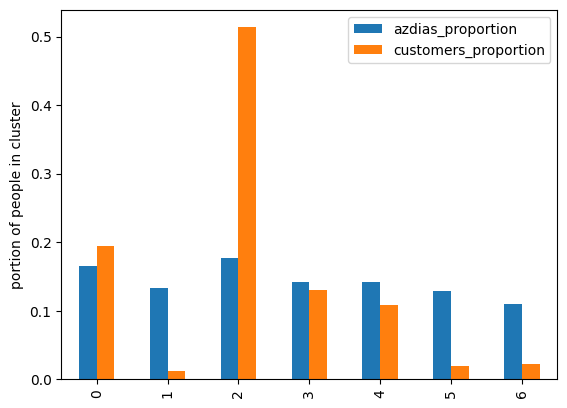

In [77]:
# That was a hard one - acutally i didn_t get the sns.countplot running and histograms gave me 
# a false view on the data (all data was underrepresented). After "years" of search - Thanks for the plot-idea  to
# https://katba-caroline.com/wp-content/uploads/2018/12/Identify_Customer_Segments-1.html

azdias_proportion, customers_proportion = [], []

x = np.arange(0, num_cluster)

for i in range(num_cluster):
    # Setting the values into proportion to the whole
    azdias_proportion.append((azdias_pred == i).sum()/ len(azdias_pred))
    customers_proportion.append((pred_customers == i).sum()/ len(pred_customers))

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html

df = pd.DataFrame({'azdias_proportion': azdias_proportion,
                   'customers_proportion': customers_proportion}, index = x)
df.plot.bar()
plt.ylabel('portion of people in cluster')
plt.show()
                        

**Finding:**<br>
With a view to the graphic Cluster 0 and 2 are overrepresented in the customer data (especially cluster 2), the rest are underrepresented. Lets take a look at cluster 2 (overrepresented) and 0 (underrepresented):

In [78]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

In [79]:
# Cheking the cluster center number 2 and its values for more interpretability
c2 = kmeans.cluster_centers_[2]
c2 = pd.Series(c2)
c2.sort_values(ascending = False).head()

2     2.154823
6     0.186437
4     0.126504
12    0.093831
14    0.055697
dtype: float64

In [80]:
# Checking the weights of the components in the cluster center 2:
pca_weights(df_impute_scale, pca_refit, 2)

SEMIO_VERT               0.346328
SEMIO_SOZ                0.263369
SEMIO_FAM                0.250307
SEMIO_KULT               0.234272
FINANZ_MINIMALIST        0.156331
RETOURTYP_BK_S           0.109321
FINANZ_VORSORGER         0.100307
W_KEIT_KIND_HH           0.090614
ALTERSKATEGORIE_GROB     0.078779
SEMIO_REL                0.070500
SEMIO_LUST               0.064319
SEMIO_MAT                0.054793
GREEN_AVANTGARDE         0.048282
ORTSGR_KLS9              0.046631
MOVEMENT                 0.046509
EWDICHTE                 0.046135
PLZ8_ANTG4               0.045486
PLZ8_ANTG3               0.045074
ARBEIT                   0.034314
WOHNDAUER_2008           0.032690
RELAT_AB                 0.031412
PLZ8_ANTG2               0.030147
KBA05_ANTG4              0.027047
WEALTH_STAGE             0.026901
ANZ_HAUSHALTE_AKTIV      0.025280
VERS_TYP                 0.014881
OST_WEST_KZ              0.014800
ANZ_HH_TITEL             0.013233
ANZ_TITEL                0.009768
KBA05_ANTG3   

In [81]:
# From https://knowledge.udacity.com/questions/906309
extracted_data = scaler.inverse_transform(np.dot(customers_pca, pca_refit.components_))[np.where(pred_customers == 2)]
extracted_data = pd.DataFrame(extracted_data, columns = missing_row_values_lt10.columns)
extracted_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENT,WEALTH_STAGE,LIFE_STAGE
0,4.240551,0.868691,5.030993,0.850045,5.046862,0.561169,1.931963,2.513513,1.023038,1.081664,4.622820,5.469125,5.158701,3.000081,4.683782,7.503165,7.469051,4.454885,4.210822,1.523680,2.274789,1.791836,1.262294,1.665012,2.281806,0.000017,1.014230,1.833006,-0.000059,1.905982,5.250326,8.838174,0.742578,0.007256,3.769109,1993.192622,-0.057849,2.590083,1.947043,0.010789,-0.076726,4.074479,3.823293,2.881885,5.065881,4.457524,0.793671,4.142168,2.297581,1.179744,1224.971673,3.064429,2.622019,0.940774,0.154863,4.716036,5.135665,1.127106,3.264148,0.160581,2.555638,2.034881,1.520862,3.326442
1,3.521951,1.051887,5.215522,0.651987,5.143482,1.390303,1.167220,2.131367,-0.027824,2.103304,3.296537,5.264629,4.741463,3.661572,3.905642,6.252859,4.867557,4.404944,5.235166,2.699677,3.428373,2.714288,2.184657,3.221884,2.948910,0.000081,0.860105,1.028131,-0.004193,3.616595,5.879248,8.789875,5.680178,0.078334,3.486200,1991.882317,-0.051137,2.782528,0.165685,0.201749,0.142620,4.096544,6.269874,1.411858,7.239078,3.510110,3.120536,4.200766,1.891311,5.221965,755.461615,3.010276,2.203835,0.779637,0.272481,3.280894,3.756682,1.328246,1.771301,0.996441,2.595647,0.962080,2.106488,3.977359
2,3.097796,1.057767,4.899639,0.813622,5.279804,0.630345,1.515034,2.637530,1.128414,2.963932,2.561092,5.798187,4.679319,3.151078,2.706540,5.913558,4.803417,3.927221,4.554086,2.370531,3.959319,4.221795,2.749160,3.081013,3.112687,0.000153,2.210766,1.807931,0.002180,2.549152,5.818365,9.201239,0.509384,-0.006642,2.287369,1992.005237,-0.084483,1.835734,1.375665,0.918941,0.039349,3.243979,6.101068,3.911003,6.477013,3.710842,2.006556,3.217317,2.871756,3.399902,1121.330080,2.169892,3.639946,2.093883,0.736136,5.250376,4.856163,3.620610,5.429487,4.468733,2.894851,2.112590,2.556464,4.218119
3,3.418707,1.142108,5.256648,0.538000,5.437217,1.156369,1.213373,2.451515,1.030610,1.594022,4.360896,5.222948,4.180848,3.290029,2.402365,6.190699,4.156319,4.084300,4.404781,2.277008,2.666348,2.752325,2.304646,2.702461,2.649851,-0.000311,1.166279,2.014107,0.000627,2.112066,4.934844,8.397498,1.133368,-0.014858,3.692180,1992.363449,0.043259,3.266380,0.676166,-0.140345,-0.011979,4.434945,5.458625,2.504126,6.065004,4.050985,2.131117,4.614503,2.455212,3.107972,1235.897502,3.225496,2.182183,0.815436,0.200711,4.916307,5.308278,2.021434,3.323052,1.531668,2.506763,2.023950,1.910943,3.147999
4,4.105830,0.894579,5.214293,0.772904,4.825322,0.383157,1.943361,2.364526,1.065975,1.063804,4.554400,5.542945,5.121549,3.186362,4.731017,7.411320,7.341604,4.412216,4.424571,1.768016,2.381103,2.130848,1.552934,1.937173,2.525403,0.000370,1.030154,1.816162,-0.000077,2.037634,5.191314,8.872575,-0.755005,0.018382,3.268360,1992.551822,0.056085,2.768956,1.551261,-0.151044,-0.030175,4.208219,4.846639,3.552381,5.265758,3.912578,0.874836,4.246999,2.269351,1.190090,465.932373,2.569298,3.023997,1.304918,0.356642,2.931707,3.265794,2.657139,4.377717,2.857841,2.555124,2.076545,1.412383,5.311060


8.317443691029215
2.6905611075419555


<function matplotlib.pyplot.show(close=None, block=None)>

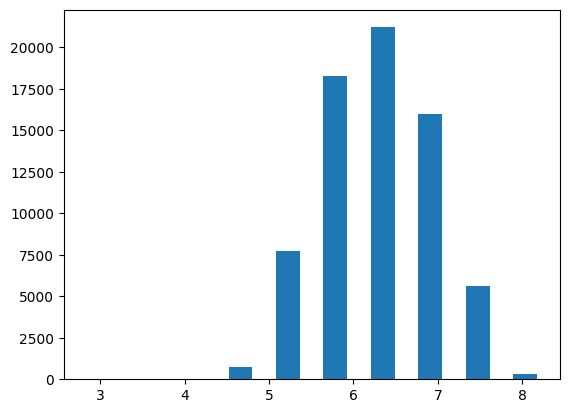

In [82]:
print(extracted_data['SEMIO_VERT'].max())
print(extracted_data['SEMIO_VERT'].min())
plt.hist(extracted_data['SEMIO_VERT'], rwidth = 0.5)
plt.show

7.4650664666790085
3.0157648328625015


<function matplotlib.pyplot.show(close=None, block=None)>

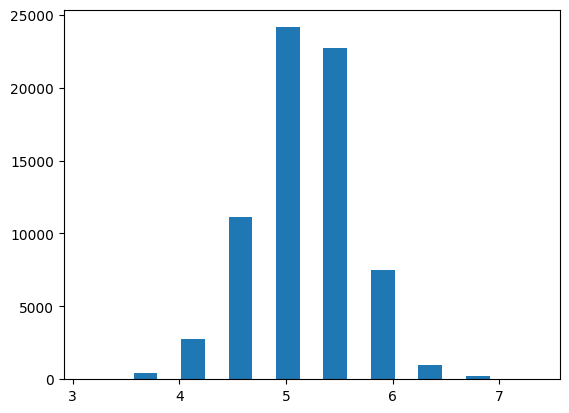

In [83]:
print(extracted_data['SEMIO_SOZ'].max())
print(extracted_data['SEMIO_SOZ'].min())
plt.hist(extracted_data['SEMIO_SOZ'], rwidth = 0.5)
plt.show

7.151536106660004
2.841031810464076


<function matplotlib.pyplot.show(close=None, block=None)>

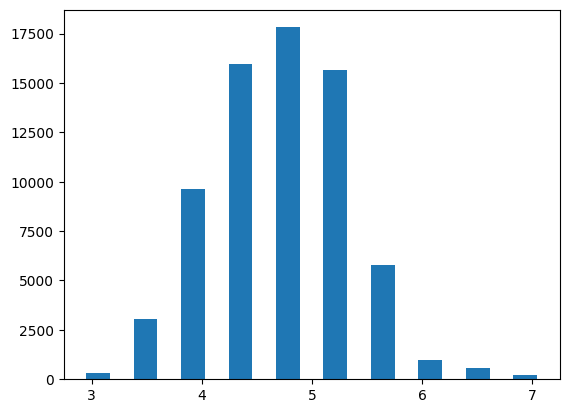

In [84]:
print(extracted_data['SEMIO_FAM'].max())
print(extracted_data['SEMIO_FAM'].min())
plt.hist(extracted_data['SEMIO_FAM'], rwidth = 0.5)
plt.show

8.18140836218937
2.800766140142755


<function matplotlib.pyplot.show(close=None, block=None)>

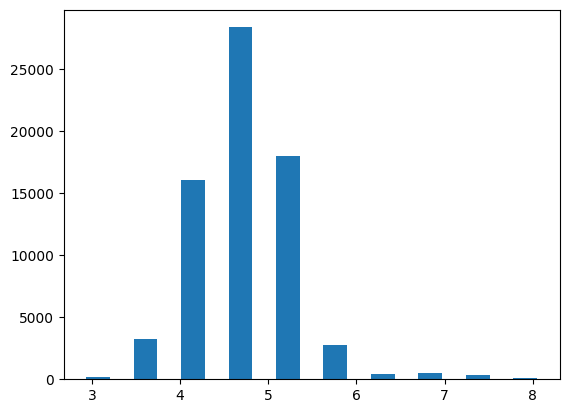

In [85]:
print(extracted_data['SEMIO_KULT'].max())
print(extracted_data['SEMIO_KULT'].min())
plt.hist(extracted_data['SEMIO_KULT'], rwidth = 0.5)
plt.show

From Dictionary.md i got the following scale for the SEMIO - Features:
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity

In [86]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

In [87]:
c1 = kmeans.cluster_centers_[1]
c1 = pd.Series(c1)
c1.sort_values(ascending = False).head()

0    4.994271
4    0.264320
5    0.261207
8    0.258020
3    0.239022
dtype: float64

In [88]:
pca_weights(df_impute_scale, pca_refit, 0)

PLZ8_ANTG3               0.226896
PLZ8_ANTG4               0.220022
WEALTH_STAGE             0.207763
HH_EINKOMMEN_SCORE       0.204404
ORTSGR_KLS9              0.197647
EWDICHTE                 0.195882
FINANZ_HAUSBAUER         0.163104
PLZ8_ANTG2               0.154412
KBA05_ANTG4              0.153162
FINANZ_SPARER            0.144062
ARBEIT                   0.144023
ANZ_HAUSHALTE_AKTIV      0.135892
RELAT_AB                 0.135711
KBA05_ANTG3              0.135498
SEMIO_PFLICHT            0.112661
SEMIO_REL                0.109925
DECADES                  0.099320
SEMIO_RAT                0.092645
SEMIO_TRADV              0.086248
SEMIO_MAT                0.077496
SEMIO_FAM                0.076399
REGIOTYP                 0.073111
FINANZ_UNAUFFAELLIGER    0.072536
SEMIO_KULT               0.070538
FINANZ_ANLEGER           0.067054
OST_WEST_KZ              0.053941
KKK                      0.044147
SEMIO_SOZ                0.041938
PLZ8_HHZ                 0.041642
SEMIO_KAEM    

In [89]:
# From https://knowledge.udacity.com/questions/906309
extracted_data_UR = scaler.inverse_transform(np.dot(customers_pca, pca_refit.components_))[np.where(pred_customers == 2)]
extracted_data_UR = pd.DataFrame(extracted_data_UR, columns = missing_row_values_lt10.columns)
extracted_data_UR.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADES,MOVEMENT,WEALTH_STAGE,LIFE_STAGE
0,4.240551,0.868691,5.030993,0.850045,5.046862,0.561169,1.931963,2.513513,1.023038,1.081664,4.622820,5.469125,5.158701,3.000081,4.683782,7.503165,7.469051,4.454885,4.210822,1.523680,2.274789,1.791836,1.262294,1.665012,2.281806,0.000017,1.014230,1.833006,-0.000059,1.905982,5.250326,8.838174,0.742578,0.007256,3.769109,1993.192622,-0.057849,2.590083,1.947043,0.010789,-0.076726,4.074479,3.823293,2.881885,5.065881,4.457524,0.793671,4.142168,2.297581,1.179744,1224.971673,3.064429,2.622019,0.940774,0.154863,4.716036,5.135665,1.127106,3.264148,0.160581,2.555638,2.034881,1.520862,3.326442
1,3.521951,1.051887,5.215522,0.651987,5.143482,1.390303,1.167220,2.131367,-0.027824,2.103304,3.296537,5.264629,4.741463,3.661572,3.905642,6.252859,4.867557,4.404944,5.235166,2.699677,3.428373,2.714288,2.184657,3.221884,2.948910,0.000081,0.860105,1.028131,-0.004193,3.616595,5.879248,8.789875,5.680178,0.078334,3.486200,1991.882317,-0.051137,2.782528,0.165685,0.201749,0.142620,4.096544,6.269874,1.411858,7.239078,3.510110,3.120536,4.200766,1.891311,5.221965,755.461615,3.010276,2.203835,0.779637,0.272481,3.280894,3.756682,1.328246,1.771301,0.996441,2.595647,0.962080,2.106488,3.977359
2,3.097796,1.057767,4.899639,0.813622,5.279804,0.630345,1.515034,2.637530,1.128414,2.963932,2.561092,5.798187,4.679319,3.151078,2.706540,5.913558,4.803417,3.927221,4.554086,2.370531,3.959319,4.221795,2.749160,3.081013,3.112687,0.000153,2.210766,1.807931,0.002180,2.549152,5.818365,9.201239,0.509384,-0.006642,2.287369,1992.005237,-0.084483,1.835734,1.375665,0.918941,0.039349,3.243979,6.101068,3.911003,6.477013,3.710842,2.006556,3.217317,2.871756,3.399902,1121.330080,2.169892,3.639946,2.093883,0.736136,5.250376,4.856163,3.620610,5.429487,4.468733,2.894851,2.112590,2.556464,4.218119
3,3.418707,1.142108,5.256648,0.538000,5.437217,1.156369,1.213373,2.451515,1.030610,1.594022,4.360896,5.222948,4.180848,3.290029,2.402365,6.190699,4.156319,4.084300,4.404781,2.277008,2.666348,2.752325,2.304646,2.702461,2.649851,-0.000311,1.166279,2.014107,0.000627,2.112066,4.934844,8.397498,1.133368,-0.014858,3.692180,1992.363449,0.043259,3.266380,0.676166,-0.140345,-0.011979,4.434945,5.458625,2.504126,6.065004,4.050985,2.131117,4.614503,2.455212,3.107972,1235.897502,3.225496,2.182183,0.815436,0.200711,4.916307,5.308278,2.021434,3.323052,1.531668,2.506763,2.023950,1.910943,3.147999
4,4.105830,0.894579,5.214293,0.772904,4.825322,0.383157,1.943361,2.364526,1.065975,1.063804,4.554400,5.542945,5.121549,3.186362,4.731017,7.411320,7.341604,4.412216,4.424571,1.768016,2.381103,2.130848,1.552934,1.937173,2.525403,0.000370,1.030154,1.816162,-0.000077,2.037634,5.191314,8.872575,-0.755005,0.018382,3.268360,1992.551822,0.056085,2.768956,1.551261,-0.151044,-0.030175,4.208219,4.846639,3.552381,5.265758,3.912578,0.874836,4.246999,2.269351,1.190090,465.932373,2.569298,3.023997,1.304918,0.356642,2.931707,3.265794,2.657139,4.377717,2.857841,2.555124,2.076545,1.412383,5.311060


3.2461715766872237
-0.6244018765577526


<function matplotlib.pyplot.show(close=None, block=None)>

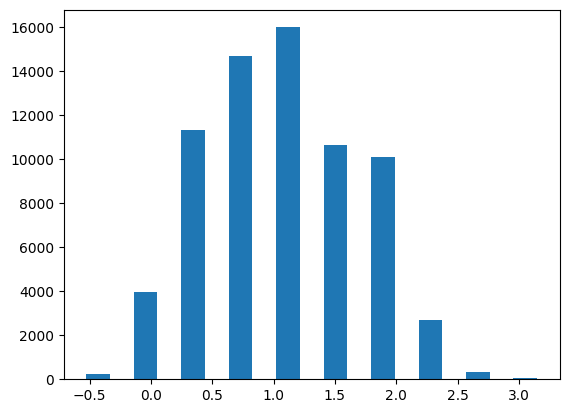

In [90]:
print(extracted_data_UR['PLZ8_ANTG3'].max())
print(extracted_data_UR['PLZ8_ANTG3'].min())
plt.hist(extracted_data_UR['PLZ8_ANTG3'], rwidth = 0.5)
plt.show

8.4. PLZ8_ANTG3
Number of 6-10 family houses in the PLZ8 region
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes

1.7085342798556882
-0.6329742505408634


<function matplotlib.pyplot.show(close=None, block=None)>

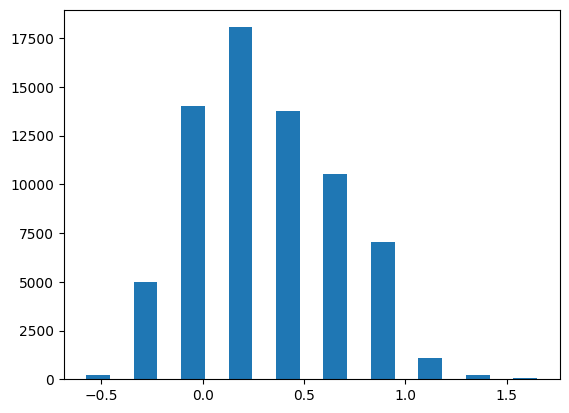

In [91]:
print(extracted_data_UR['PLZ8_ANTG4'].max())
print(extracted_data_UR['PLZ8_ANTG4'].min())
plt.hist(extracted_data_UR['PLZ8_ANTG4'], rwidth = 0.5)
plt.show

8.5. PLZ8_ANTG4
Number of 10+ family houses in the PLZ8 region
- -1: unknown
-  0: no 10+ family homes
-  1: lower share of 10+ family homes
-  2: high share of 10+ family homes

4.986357824294145
-0.1830302421670149


<function matplotlib.pyplot.show(close=None, block=None)>

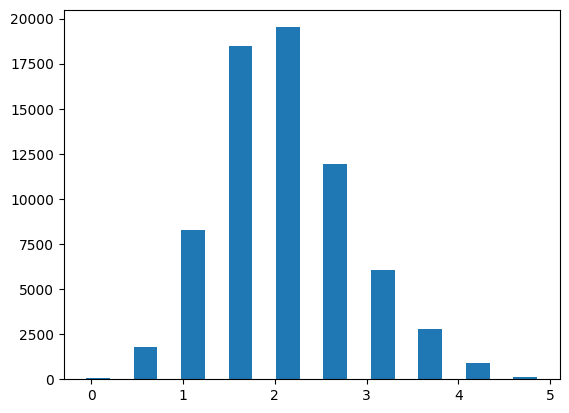

In [92]:
print(extracted_data_UR['WEALTH_STAGE'].max())
print(extracted_data_UR['WEALTH_STAGE'].min())
plt.hist(extracted_data_UR['WEALTH_STAGE'], rwidth = 0.5)
plt.show

WEALTH_STAGE:

<ul>
    <li>1: Wealthy Households
    <li>2: Prosperous Households
    <li>3: Comfortable Households
    <li>4: Less Affluent Households
    <li>5: Poorer Households
</ul>

### Discussion 3.3: Compare Customer Data to Demographics Data

Especially **Cluster 2** is a match for the target audience of the company.
It specifies the personality topology in the following translations:
<ul>
    <li>socially-minded
    <li>family-minded
    <li>dreamful
    <li>cultural-minded
</ul>
These personality types have the most influence for this target group. With a deeper view into that the people who have an average to low affinity to these values and personality types are most likely the best target audience.

*OLD INFERENCE: So the people following these values and personalities are the best target audience for the company.*

**Cluster 0** is also overrepresented.



And **Cluster 1** is definitely out of the target group.
This includes 
<ul>
    <li>Number of 6-10 family houses in the PLZ8 region
    <li>Number of 10+ family houses in the PLZ8 region
    <li>Wealth-Stage typology
</ul>
Looking at this cluster, the region with lower share of 6-10 family homes and no 10+ family homes are included - and more prosperous households. So we could assume, these are more wealthy households with less than 6 family homes in the PLZ8 region.

Also **Cluster 5** and **Cluster 6** are definitely out of the target group.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.